<a href="https://colab.research.google.com/github/ricardogr07/trabajo-final-aprendizaje/blob/main/src/Analisis_ML_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de dataset

## Importar librerías

In [ ]:
# Correr esta celda unicamente si se hace desde Colab
%pip install pandas numpy

!git clone https://github.com/ricardogr07/trabajo-final-aprendizaje.git
%cd trabajo-final-aprendizaje/src
from evaluation_functions import *

In [11]:
# Manipulación y análisis de datos
import pandas as pd
import numpy as np


# Visualización de datos
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

## Carga y Preprocesamiento de Datos

En esta sección se carga el conjunto de datos de los archivos .data que contiene información sobre enfermedades cardíacas, disponible en el repositorio de UCI Machine Learning. Las columnas del conjunto de datos se especifican manualmente ya que el archivo no tiene encabezados. El dataset contiene información sobre varios factores de riesgo y el objetivo es predecir la presencia de una enfermedad cardíaca (`target`).

### Carga del dataset

In [12]:
cleveland_data_file_path = '../dataset/cleveland.data'
hungarian_data_file_path = '../dataset/hungarian.data'
switzerland_data_file_path = '../dataset/switzerland.data'
va_data_file_path = '../dataset/va.data'

column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

# Cargar todos los datos y generar un solo dataframe
try:
    data_cleveland = pd.read_csv(cleveland_data_file_path, names = column_names)
    data_hungarian = pd.read_csv(hungarian_data_file_path, names = column_names)
    data_switzerland = pd.read_csv(switzerland_data_file_path, names = column_names)
    data_va = pd.read_csv(va_data_file_path, names = column_names)

    # Agregar location como parte de las variables, pues se usan las 4 bases de datos
    data_cleveland['location'] = 0
    data_hungarian['location'] = 1
    data_switzerland['location'] = 2
    data_va['location'] = 3

    df = pd.concat([data_cleveland, data_hungarian, data_switzerland, data_va], ignore_index=True)

except Exception as e:
    print(f"Error reading the file: {e}")


### Exploración inicial del dataset

En esta sección se realiza una inspección de la estructura del conjunto de datos para entender el tipo de variables con las que estamos trabajando. Se revisa la cantidad de entradas, los nombres de las columnas, los tipos de datos, y si hay valores faltantes. Es importante notar que algunas columnas tienen el tipo `object`, lo que indica que pueden contener valores categóricos o valores que no han sido correctamente identificados como numéricos.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    float64
 1   sex       920 non-null    float64
 2   cp        920 non-null    float64
 3   trestbps  920 non-null    object 
 4   chol      920 non-null    object 
 5   fbs       920 non-null    object 
 6   restecg   920 non-null    object 
 7   thalach   920 non-null    object 
 8   exang     920 non-null    object 
 9   oldpeak   920 non-null    object 
 10  slope     920 non-null    object 
 11  ca        920 non-null    object 
 12  thal      920 non-null    object 
 13  target    920 non-null    int64  
 14  location  920 non-null    int64  
dtypes: float64(3), int64(2), object(10)
memory usage: 107.9+ KB


In [14]:
for columna in df.columns:
    valores_unicos = df[columna].unique()
    print(f"Valores únicos en la columna '{columna}':")
    print(valores_unicos)
    print('\n')

Valores únicos en la columna 'age':
[63. 67. 37. 41. 56. 62. 57. 53. 44. 52. 48. 54. 49. 64. 58. 60. 50. 66.
 43. 40. 69. 59. 42. 55. 61. 65. 71. 51. 46. 45. 39. 68. 47. 34. 35. 29.
 70. 77. 38. 74. 76. 28. 30. 31. 32. 33. 36. 72. 73. 75.]


Valores únicos en la columna 'sex':
[1. 0.]


Valores únicos en la columna 'cp':
[1. 4. 3. 2.]


Valores únicos en la columna 'trestbps':
[145.0 160.0 120.0 130.0 140.0 172.0 150.0 110.0 132.0 117.0 135.0 112.0
 105.0 124.0 125.0 142.0 128.0 170.0 155.0 104.0 180.0 138.0 108.0 134.0
 122.0 115.0 118.0 100.0 200.0 94.0 165.0 102.0 152.0 101.0 126.0 174.0
 148.0 178.0 158.0 192.0 129.0 144.0 123.0 136.0 146.0 106.0 156.0 154.0
 114.0 164.0 '130' '120' '140' '170' '100' '105' '110' '125' '150' '98'
 '112' '145' '190' '160' '115' '142' '180' '132' '135' '?' '108' '124'
 '113' '122' '92' '118' '106' '200' '138' '136' '128' '155' '95' '165'
 '80' '185' '126' '152' '116' '0' '144' '154' '104' '134' '178' '146'
 '158' '102' '96' '172' '156' '114' '127']




Al examinar los valores únicos presentes en las columnas se descubre que existen múltiples columnas que contienen el valor '?' en lugar de un valor numérico. Este es un indicador de datos faltantes o incorrectos que deberán ser manejados antes de continuar con el análisis.
Adicionalmente, hay columnas que tienen como valor un `string` en lugar de un `int` o `float`, por lo que va a ser necesario estandarizar estos valores.

### Preprocesar Datos

En esta sección, se manejan los valores faltantes representados por el símbolo `'?'`:

* Primero, se reemplazan estos valores por `NaN` (not a number) para que pandas pueda identificarlos como datos faltantes. 

* Luego, se convierten las columnas afectadas en tipo `float`, ya que originalmente estaban mal interpretadas como `object`. 

* Posteriormente, se eliminan las filas que contienen valores nulos. 

* Finalmente, se revisan estadísticas descriptivas del dataset limpio.

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    float64
 1   sex       920 non-null    float64
 2   cp        920 non-null    float64
 3   trestbps  920 non-null    object 
 4   chol      920 non-null    object 
 5   fbs       920 non-null    object 
 6   restecg   920 non-null    object 
 7   thalach   920 non-null    object 
 8   exang     920 non-null    object 
 9   oldpeak   920 non-null    object 
 10  slope     920 non-null    object 
 11  ca        920 non-null    object 
 12  thal      920 non-null    object 
 13  target    920 non-null    int64  
 14  location  920 non-null    int64  
dtypes: float64(3), int64(2), object(10)
memory usage: 107.9+ KB


In [17]:
# Reemplazar los valores '?' por NaN
df.replace('?', np.nan, inplace=True)

# Convertir las columnas que deben ser numéricas a tipo float (algunas están como objetos)
df = df.apply(pd.to_numeric, errors='coerce')

# Verificar los datos nulos después del reemplazo
display(df.isnull().sum())

age             0
sex             0
cp              0
trestbps       59
chol           30
fbs            90
restecg         2
thalach        55
exang          55
oldpeak        62
slope         309
ca            611
thal          486
target          0
location        0
target_cat      0
dtype: int64

Existe un gran número de datos faltantes para las columnas `slope`, `ca` y `thal`. Sería necesario eliminar estas características para tener una mayor cantidad de datos, pero podría hacer el modelado menos exacto. También es posible eliminar los datos faltantes para tener la mayor cantidad de características para el modelo. 

Vamos por el momento a eliminar los datos incompletos para evaluar un modelo con todas las características, posteriormente se tomará el modelo sin estas características y compararemos cuál nos da mejores métricas de desempeño. 

Dependiendo de esto, volveremos a este paso para determinar nuevamente que es lo que tenemos que hacer para maximizar la información de nuestro modelo.

In [18]:
# Eliminar filas con valores nulos
df.dropna(inplace=True)

# Estadísticas descriptivas
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,location,target_cat
count,299.000000,299.00000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000
mean,54.521739,0.67893,3.163880,131.715719,246.785953,0.143813,0.989967,149.327759,0.331104,1.058528,1.605351,0.672241,4.745819,0.946488,0.013378,0.464883
std,9.030264,0.46767,0.964069,17.747751,52.532582,0.351488,0.994903,23.121062,0.471399,1.162769,0.616962,0.937438,1.940977,1.230409,0.182695,0.499601
min,29.000000,0.00000,1.000000,94.000000,100.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000
25%,48.000000,0.00000,3.000000,120.000000,211.000000,0.000000,0.000000,132.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000
50%,56.000000,1.00000,3.000000,130.000000,242.000000,0.000000,1.000000,152.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000,0.000000,0.000000
75%,61.000000,1.00000,4.000000,140.000000,275.500000,0.000000,2.000000,165.500000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000,0.000000,1.000000
max,77.000000,1.00000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000,3.000000,1.000000


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 299 entries, 0 to 748
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         299 non-null    float64
 1   sex         299 non-null    float64
 2   cp          299 non-null    float64
 3   trestbps    299 non-null    float64
 4   chol        299 non-null    float64
 5   fbs         299 non-null    float64
 6   restecg     299 non-null    float64
 7   thalach     299 non-null    float64
 8   exang       299 non-null    float64
 9   oldpeak     299 non-null    float64
 10  slope       299 non-null    float64
 11  ca          299 non-null    float64
 12  thal        299 non-null    float64
 13  target      299 non-null    int64  
 14  location    299 non-null    int64  
 15  target_cat  299 non-null    int64  
dtypes: float64(13), int64(3)
memory usage: 39.7 KB


Tras eliminar todos los datos faltantes, tenemos un total de 299 valores para nuestras 15 características y nuestro target. 

Vamos a revisar ahora nuestra variable generada `location` y nuestra variable objetivo.

In [22]:
display(df['location'].value_counts())

display(df['target'].value_counts())

location
0    297
1      1
3      1
Name: count, dtype: int64

target
0    160
1     56
2     35
3     35
4     13
Name: count, dtype: int64

Para `location` tenemos que se encuentra muy desbalanceada, por lo que probablemente no aporte ninguna información relevante en este modelo actual, por lo que vamos a decidir eliminarla del dataset.

Para `target` la clasificación es algo desbalanceada, vemos que los valores del 1 al 4 incluyen múltiples niveles de la enfermedad, pero para nuestros fines, únicamente nos interesa saber si el paciente tiene o no la enfermedad dadas las características mencionadas anteriormente. 

Por lo anterior, se ha decidido usar una variable binaria `target_cat` que sea 0 si no existe la enfermedad y 1 si esta presente.

In [25]:
# Eliminar la columna location, pues no aporta información relevante
df.drop(columns=['location'])

# Crear una nueva columna 'target_cat' que sea binaria (1 si target > 0, 0 en caso contrario)
df['target_cat'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

Ahora podemos observar la distribución de la variable objetivo, y definir la clasificación binaria que haremos siendo:

0 - No existe enfermedad cardiovascular

1 - Existe enfermedad cardiovascular

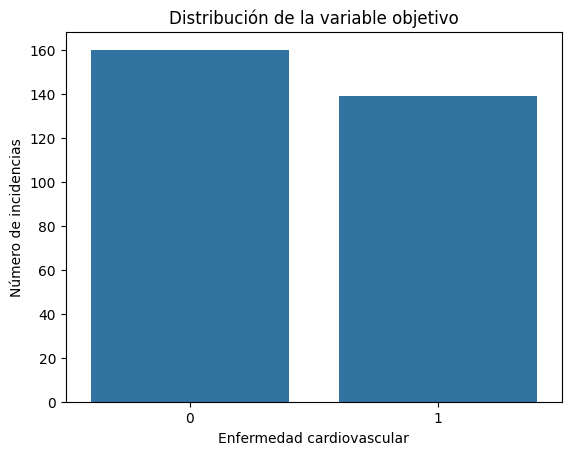

In [29]:
# Visualización de la distribución de la variable objetivo
sns.countplot(x='target_cat', data=df)
plt.title('Distribución de la variable objetivo')
plt.xlabel('Enfermedad cardiovascular')
plt.ylabel('Número de incidencias')
plt.show()

Vemos que las clases están un poco desbalanceadas, por lo que probablemente tengas que hacer algún tipo de rebalanceo como preprocesamiento antes de hacer el ajuste del modelo.

## Análisis exploratorio de datos


## Selección de modelo usando técnicas de aprendizaje supervisado


### Selección de características


### Validación de balanceo de clases


### Selección de modelo supervisado


### Ajuste de hiperparámetros del modelo


### Evaluación del modelo seleccionado


## Análisis de clúster con aprendizaje no supervisado


### PCA


### Clustering
